In [2]:
# Importing the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import random

In [3]:
# Load the dataset
dataset = pd.read_csv(r'input/data/240624_validation_data.csv')

# Extract the time, forecasted demand and actual demand
time = dataset['time']
time = pd.to_datetime(time, utc=True)
forecast_demand = dataset['predicted heat']
actual_demand = dataset['delivered heat']

# Create a dataframe
df_data = pd.DataFrame({'time' : time, 'actual_demand': actual_demand, 'forecast_demand': forecast_demand})
df_data['hour']=time.dt.hour

# Calculate the error and absolute error
df_data['error']= df_data['actual_demand'] - df_data['forecast_demand']

# Calculate the mean of the error for whole dataset
mu_all = df_data['error'].mean()
sigma_all = df_data['error'].std()
print('Mean of the mean of the error of each hour:', mu_all)
print('Standard deviation of the mean of the error of each hour:', sigma_all)

Mean of the mean of the error of each hour: -8.39020298257356
Standard deviation of the mean of the error of each hour: 31.42172005784749


In [4]:
# Select the date for which you want to extract the data
selected_date = '2023-04-01'

# Number of scenarios
num_scenarios = 10

# Extract the data for the selected date
daily_date = df_data[df_data['time'].dt.date == pd.to_datetime(selected_date).date()].reset_index(drop=True)
daily_date = daily_date[['time', 'hour', 'actual_demand', 'forecast_demand', 'error']]
if(len(daily_date)==24):
    print('The selected date has 24 hours')
else:
    print('The selected date does not have 24 hours')

daily_date

The selected date has 24 hours


,time,hour,actual_demand,forecast_demand,error
0,2023-04-01 00:00:00+00:00,0,45.141668,79.256436,-34.114768
1,2023-04-01 01:00:00+00:00,1,71.408335,88.850384,-17.442050
2,2023-04-01 02:00:00+00:00,2,234.970838,166.624694,68.346144
3,2023-04-01 03:00:00+00:00,3,146.212502,113.137177,33.075326
4,2023-04-01 04:00:00+00:00,4,131.770836,118.939521,12.831315
5,2023-04-01 05:00:00+00:00,5,129.470836,124.614834,4.856001
6,2023-04-01 06:00:00+00:00,6,160.633337,125.941581,34.691755
7,2023-04-01 07:00:00+00:00,7,168.050002,118.988194,49.061808
8,2023-04-01 08:00:00+00:00,8,162.475003,113.102637,49.372366
9,2023-04-01 09:00:00+00:00,9,96.350001,103.574392,-7.224391


---

## First Methode

In [14]:
# Calculate the mean and standard deviation of the error of each hour
error = df_data.groupby('hour')['error'].agg(['mean', 'std']).reset_index()
error  = error.rename(columns={'mean': 'mu', 'std': 'sigma'})
error

,hour,mu,sigma
0,0,-12.731658,25.018753
1,1,-8.717702,25.787823
2,2,38.628091,40.062211
3,3,-11.219356,35.896108
4,4,4.661963,29.891503
5,5,-3.150345,30.625035
6,6,-11.665525,28.687483
7,7,-8.965185,30.891632
8,8,-4.254730,29.094431
9,9,-9.849401,33.982801


In [17]:
# Generate scenarios for the selected date
forecast_demand = daily_date['forecast_demand']

scenarios = np.zeros((num_scenarios, 24))


for i in range(24):
    mu = error.loc[error['hour'] == i, 'mu'].values[0]
    sigma = error.loc[error['hour'] == i, 'sigma'].values[0]
    print('Hour:', i, 'Mean:', mu, 'Standard deviation:', sigma)
    hourly_scenarios = np.random.normal(mu, sigma, num_scenarios)
    print('Hourly scenarios:', hourly_scenarios)
    scenarios[:, i] = forecast_demand[i] + hourly_scenarios

scenarios_df = pd.DataFrame(scenarios)


# Calculate the probability for each scenario
probabilities = stats.norm(mu_all, sigma_all).pdf(scenarios - forecast_demand.values.reshape(1, -1))
probabilities = probabilities.prod(axis=1)

# Add the probabilities to the scenarios dataframe
scenarios_df['probability'] = probabilities
scenarios_df


Hour: 0 Mean: -12.731658021190215 Standard deviation: 25.018753157221795
Hourly scenarios: [-36.98746114  -0.0627738  -52.20674648  22.31902573 -16.7532831
 -32.9570131  -25.42453385 -10.73352056 -12.41173683 -12.30275515]
Hour: 1 Mean: -8.717701939869812 Standard deviation: 25.787822594592562
Hourly scenarios: [-41.65990418 -62.32538997 -12.93986751 -31.14372787  19.25453098
 -25.51937272 -40.42891664  31.04924147 -30.97535663 -36.76526634]
Hour: 2 Mean: 38.62809145641247 Standard deviation: 40.06221098717317
Hourly scenarios: [-44.54227664  87.94451683  83.83437704   0.95205452  89.2798882
  35.73736142  29.10658655  59.66038421  74.74517447  75.26795996]
Hour: 3 Mean: -11.219355528775246 Standard deviation: 35.89610812413864
Hourly scenarios: [ 19.26546301 -33.86867731 -10.43311677  20.93344126   7.30310246
  29.00952581   3.16697408 -26.71032794  31.0761438  -14.9906282 ]
Hour: 4 Mean: 4.6619634940865975 Standard deviation: 29.89150310430875
Hourly scenarios: [ -1.60452095 -44.3267

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,probability
0,42.268975,47.190480,122.082418,132.402640,117.335000,161.320253,124.060711,150.666902,108.268284,81.062967,...,131.474150,75.401309,121.175941,69.025554,49.180497,73.543617,30.720360,18.858822,97.529545,1.922933e-50
1,79.193662,26.524994,254.569211,79.268500,74.612797,118.799002,128.964469,89.668290,117.023844,120.122963,...,93.281538,127.553441,97.154644,84.970058,121.010209,38.718102,70.131940,26.142282,48.485155,4.592411e-52
2,27.049689,75.910517,250.459071,102.704060,110.012185,163.099119,103.786992,116.694648,122.917957,80.727932,...,85.947657,151.396757,166.796854,146.735339,76.474172,53.992304,43.521453,86.936496,93.230892,8.695630e-53
3,101.575462,57.706656,167.576749,134.070618,128.326268,88.842670,109.499019,133.033680,156.932714,56.269449,...,49.398670,125.137197,104.610331,95.052657,42.937587,99.852302,58.601612,52.166596,37.809554,1.837054e-50
4,62.503153,108.104915,255.904582,120.440279,122.499987,113.122177,166.512175,135.537702,138.336273,109.691159,...,11.792339,108.184249,135.582587,86.547304,76.634544,32.626126,44.759237,22.634060,56.458046,4.654125e-54
5,46.299423,63.331012,202.362056,142.146703,76.446974,87.788420,104.550545,103.912518,149.187755,118.627493,...,116.698259,82.614438,192.645657,157.030715,101.655438,27.071554,38.498071,69.844221,70.344154,1.152543e-52
6,53.831902,48.421468,195.731281,116.304151,103.156177,113.812516,125.748737,95.605045,104.821141,-17.980453,...,109.918366,86.763559,79.197003,104.101519,86.838323,70.577088,56.731614,81.580941,78.787992,2.188303e-50
7,68.522915,119.899626,226.285078,86.426849,94.967199,133.402258,221.707367,72.610886,80.039613,73.407812,...,116.736673,138.995193,134.469548,92.024016,113.038853,36.467046,74.206059,29.429315,82.785393,3.030827e-52
8,66.844699,57.875028,241.369869,144.213321,129.338932,144.522683,53.757356,139.292446,90.443351,41.722567,...,64.787183,104.310493,110.296067,49.304550,122.403124,88.425467,53.165313,75.734131,91.147940,1.334754e-52
9,66.953681,52.085118,241.892654,98.146549,103.446727,98.550332,126.578017,125.283152,116.863630,68.886395,...,71.102921,105.942979,40.475192,84.566903,106.981730,37.582851,69.279884,2.302187,81.447881,5.054647e-53


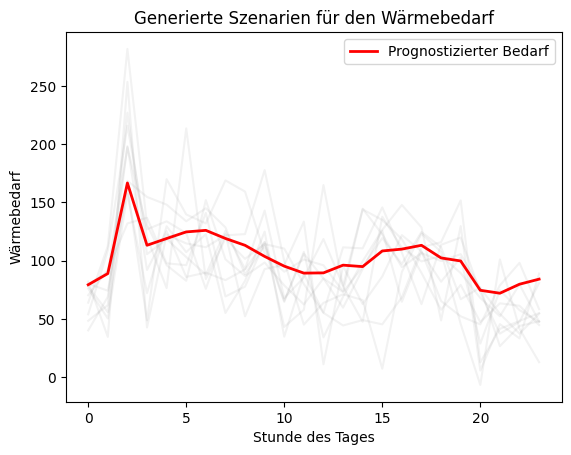

In [7]:
plt.plot(scenarios.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

---

## Second Methode: Monte Carlo Sampling and Roulette Wheel Mechanism


In [8]:
# number of intervals
num_intervals = 7  
intervals = np.linspace(mu_all - 3*sigma_all, mu_all + 3*sigma_all, 8)
interval_centers = (intervals[:-1] + intervals[1:]) / 2  
print('Intervals:',intervals)
print('Interval Centers:',interval_centers)

# calculate the probabilities
probabilities = [stats.norm.cdf(intervals[i+1], mu_all, sigma_all) - stats.norm.cdf(intervals[i], mu_all, sigma_all) for i in range(len(intervals)-1)]
cum_probabilities = np.cumsum(probabilities)

# print the probabilities
print('Probabilities:',probabilities)
print('Edge on Scale 0.XX-0.99X Probabilities:',cum_probabilities)

# Function to randomly select an interval based on the CDF

def select_interval(cumulative_probabilities):
    rnd = random.random()
    for i, cp in enumerate(cumulative_probabilities):
        if rnd <= cp:
            return i
    return len(cumulative_probabilities) - 1


Intervals: [-102.65536316  -75.72246025  -48.78955734  -21.85665444    5.07624847
   32.00915138   58.94205428   85.87495719]
Interval Centers: [-89.1889117  -62.2560088  -35.32310589  -8.39020298  18.54269992
  45.47560283  72.40850574]
Probabilities: [0.014712387572198223, 0.08320911123950271, 0.2348461740542938, 0.33176485820475055, 0.23484617405429364, 0.0832091112395027, 0.014712387572198171]
Edge on Scale 0.XX-0.99X Probabilities: [0.01471239 0.0979215  0.33276767 0.66453253 0.89937871 0.98258782
 0.9973002 ]


In [9]:
# Generate scenarios
T = 24  # Number of time steps
scenarios = []

for _ in range(num_scenarios):
    scenario = []
    for t in range(T):
        interval_index = select_interval(cum_probabilities)
        scenario.append(interval_centers[interval_index])
    scenarios.append(scenario)

    
# Calculate normed probability for each scenario
scenario_probabilities = np.prod([[probabilities[select_interval(cum_probabilities)] for _ in range(T)] for _ in range(num_scenarios)], axis=1)
normalized_probabilities = scenario_probabilities / scenario_probabilities.sum()

# Convert scenarios to DataFrame for better visualization
scenarios_mu_df = pd.DataFrame(scenarios, columns=[f'Time_{t}' for t in range(T)])
probabilities_df = pd.DataFrame(normalized_probabilities, columns=['Probability'])


In [10]:
probabilities_df


,Probability
0,1.501768e-05
1,2.387381e-04
2,3.347119e-07
3,1.201183e-04
4,3.035619e-02
5,9.630749e-01
6,6.765746e-04
7,2.700518e-03
8,1.199879e-04
9,2.697585e-03


In [11]:
# Add the predicted thermal demand to the error scenarios to get the actual thermal demand scenarios
scenarios_df = scenarios_mu_df.apply(lambda row: daily_date['forecast_demand'] + row.values, axis=1)

# Create csv file for the scenarios
scenarios_df.to_csv('output/scenarios.csv', index=False)

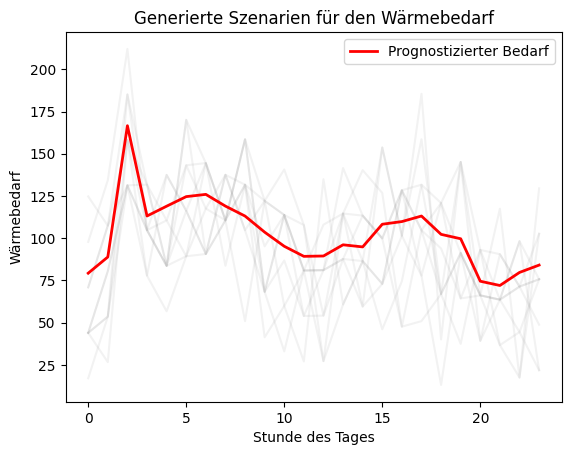

In [12]:
plt.plot(scenarios_df.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

## Szenarien Reduktion

In [13]:
# Importing the libraries

from sklearn.cluster import KMeans
from scipy.stats import entropy

### Backward Scenario Reduction Methode
Ergänzen.

### Improved k-means Clustering

Ergänzen.